# 1. Зниження розмірності і візуалізація даних
Застосуйте методи зниження розмірності sklearn.decomposition.PCA і sklearn.manifold.TSNE для візуалізації даних, з якими ви працювали в лабораторній № 1 (знижуючи розмірність до двох). Візуалізуйте результат.


In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

glass_data = pd.read_csv("glass/glass.csv")
glass_data = glass_data.dropna().reset_index().drop("index",axis=1)

X = glass_data.drop("Type", axis=1)
y = glass_data['Type']

scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### PCA

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

In [4]:
import numpy as np

exp_var_pca = pca.explained_variance_ratio_ 
cum_sum_eigenvalues = np.cumsum(exp_var_pca) 

print("Відсоток дисперсії, пояснений кожним із вибраних компонентів", exp_var_pca)
print("кумулятвна сума",cum_sum_eigenvalues)

Відсоток дисперсії, пояснений кожним із вибраних компонентів [0.45429569 0.17990097]
кумулятвна сума [0.45429569 0.63419666]


In [5]:
pca_df = pd.DataFrame(data = X_pca, columns = ['Principal component 1', 'Principal component 2'])

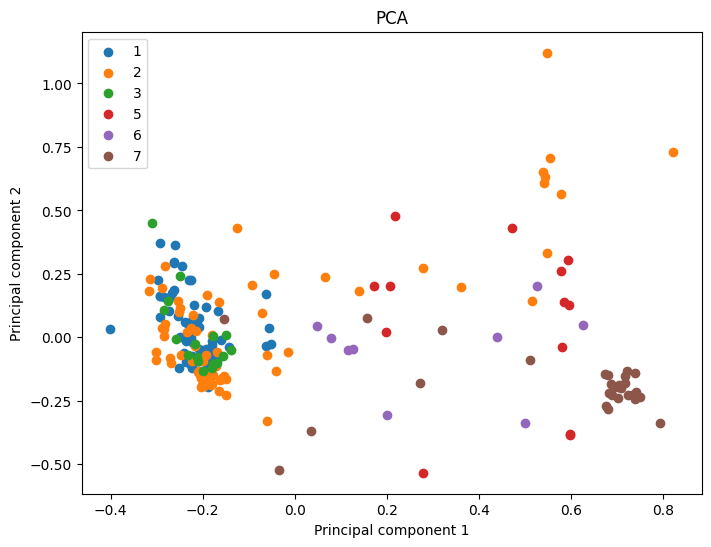

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for value in y.unique():
    index = glass_data.Type == value
    plt.scatter(pca_df.loc[index, 'Principal component 1'], pca_df.loc[index, 'Principal component 2'])
    
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.title("PCA")
plt.legend(y.unique())

### TSNE

In [7]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_std)

In [8]:
tsne_df = pd.DataFrame(data = X_tsne, columns = ['TSNE component 1', 'TSNE component 2'])

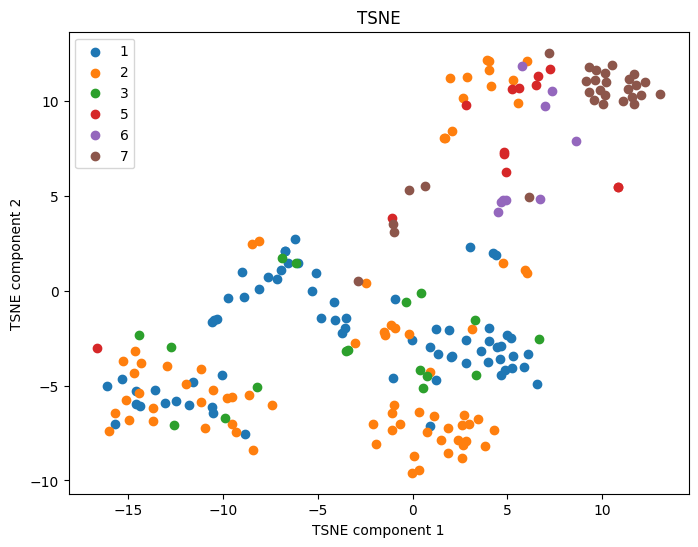

In [9]:
plt.figure(figsize=(8,6))

for value in y.unique():
    index = glass_data.Type == value
    plt.scatter(tsne_df.loc[index, 'TSNE component 1'], tsne_df.loc[index, 'TSNE component 2'])
    
plt.xlabel('TSNE component 1')
plt.ylabel('TSNE component 2')
plt.title("TSNE")
plt.legend(y.unique())

# 2. Кластерний аналіз
1) За допомогою алгоритму k-means зробіть квантування зображення (видалення візуально надлишкової інформації) з глибиною 64, 32, 16 та 8 рівнів для будь-якого обраного самостійно зображення.

In [10]:
from sklearn.cluster import KMeans
from sklearn.datasets import load_sample_image
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

In [11]:
man =  plt.imread("img.jpg")
man = man/255

In [12]:
# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(man.shape)
assert d == 3
image_array = np.reshape(man, (w * h, d))

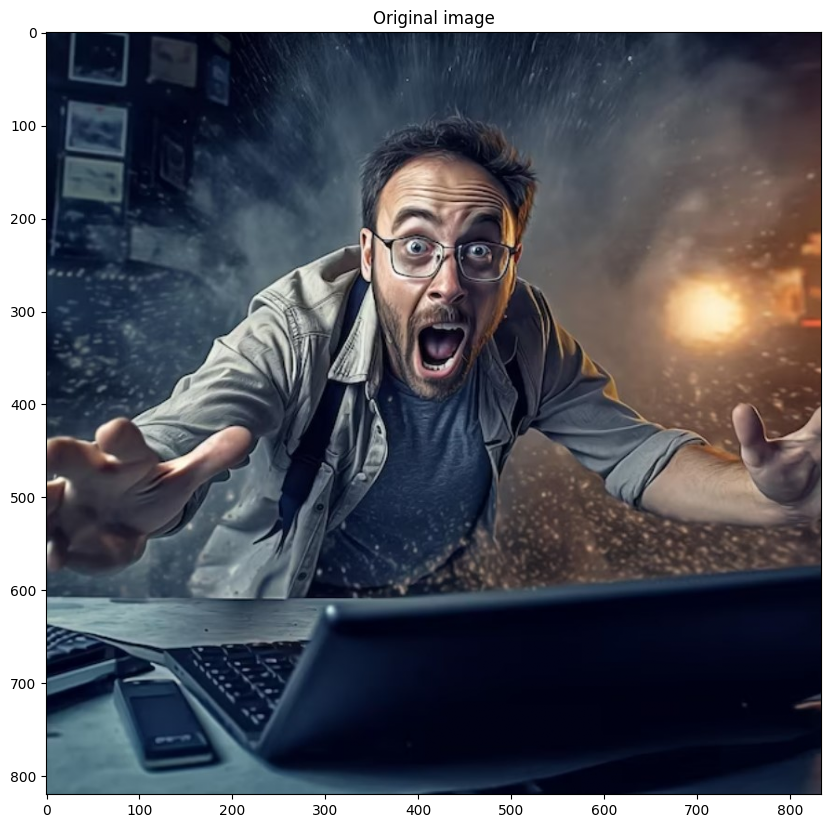

In [13]:
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)

plt.figure(figsize=(10,10))

plt.figure(1)
plt.clf()
plt.title("Original image")
plt.imshow(man)

c:\Users\fvr20\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fvr20\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fvr20\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\fvr20\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

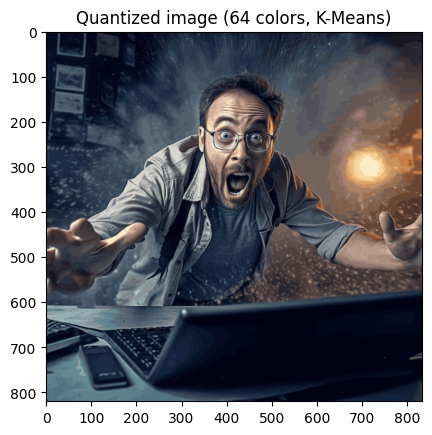

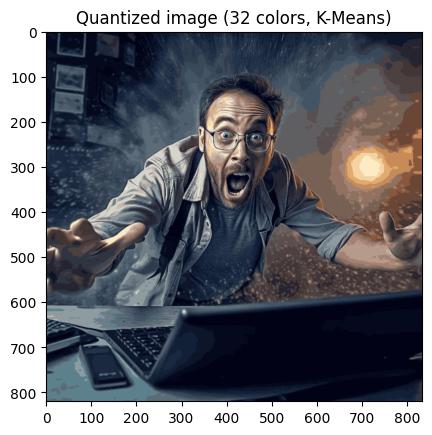

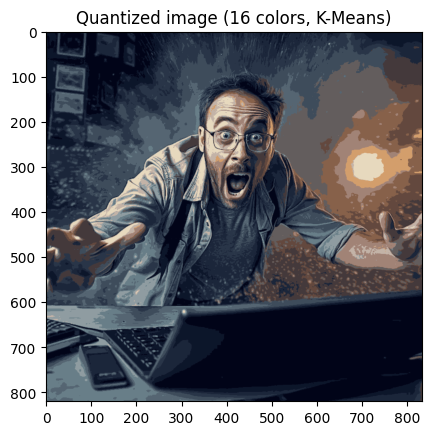

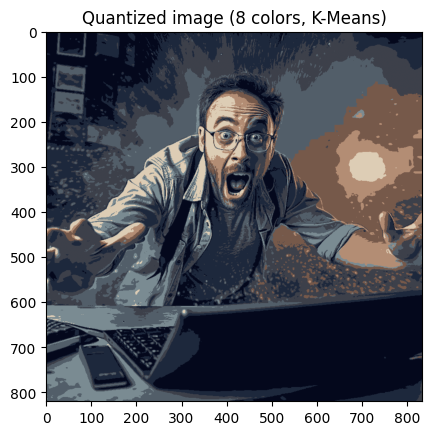

In [14]:
def recreate_image(codebook, labels, w, h):
    return codebook[labels].reshape(w, h, -1)
    
n_colors = [64, 32, 16, 8]

for n in n_colors:
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)

    plt.figure(n_colors.index(n)+1)
    plt.title(f"Quantized image ({n} colors, K-Means)")
    plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

# 3. Обробка та класифікація текстових даних
Завантажте набір текстових даних (з мітками класів). Проведіть передобробку даних (видаліть стоп-слова, пунктуацію), за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). Проведіть класифікацію текстових даних, зробіть оцінку якості. 

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

In [16]:
data = pd.read_csv("sms-spam-collection-a-more-diverse-dataset/train.csv")

### Oчистка

In [17]:
import re

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = word_tokenize(text) #Tokenization
    words = [word.lower() for word in words if word.isalnum()] #to Lowercase
    words = [word for word in words if word not in stopwords.words("english")] #Remove Stopwords
    return " ".join(words) #Concate tokens

data['clear_sms'] = data['sms'].apply(preprocess_text)

In [18]:
data.head()

,sms,label,clear_sms
0,"Go until jurong point, crazy.. Available only ...",0,go jurong point crazy available bugis n great ...
1,Ok lar... Joking wif u oni...\n,0,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts st ...
3,U dun say so early hor... U c already then say...,0,u dun say early hor u c already say
4,"Nah I don't think he goes to usf, he lives aro...",0,nah think goes usf lives around though


In [19]:
words_label_0 = " ".join(list(data[data['label']==0]['clear_sms'])).split()
words_label_1 = " ".join(list(data[data['label']==1]['clear_sms'])).split()

print("The most popular words in normal sms: ", FreqDist(words_label_0).most_common()[:10])
print("\n\nThe most popular words in spam sms: ", FreqDist(words_label_1).most_common()[:10])



The most popular words in normal sms:  [('u', 1042), ('gt', 318), ('lt', 316), ('get', 311), ('ok', 288), ('go', 256), ('ur', 247), ('got', 246), ('call', 238), ('know', 237)]


The most popular words in spam sms:  [('call', 370), ('free', 228), ('u', 186), ('p', 180), ('txt', 170), ('ur', 144), ('mobile', 129), ('stop', 128), ('text', 126), ('claim', 113)]


### Векторизація

In [20]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X = tfidf_vectorizer.fit_transform(data['clear_sms']).toarray()
y = data['label']

### Класифікація

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
X_train.shape

(4459, 1000)

In [23]:
from sklearn.neighbors import KNeighborsClassifier

1
2
3
4
5
6
7
8
9


Text(0, 0.5, 'Accuracy Score')

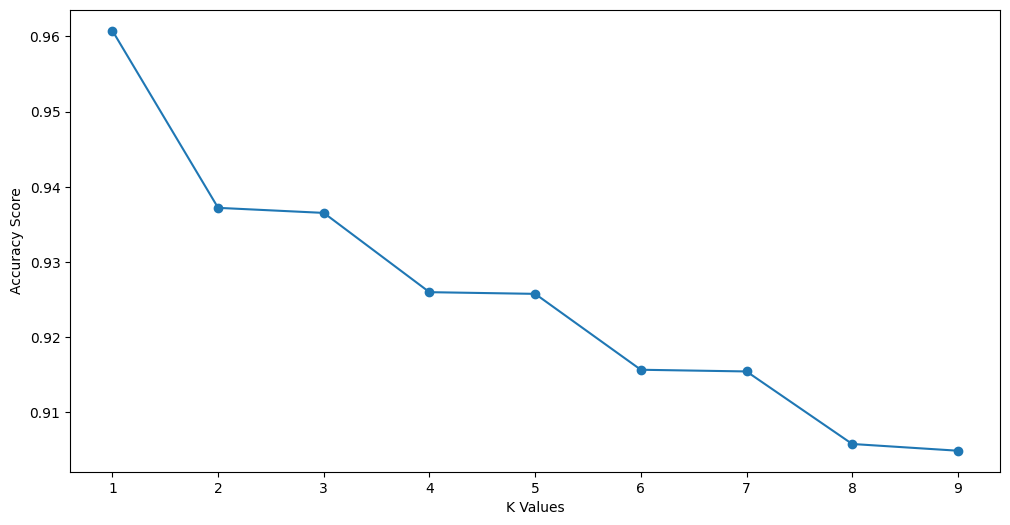

In [24]:
#Підбираємо параметри для кнн
from sklearn.model_selection import cross_val_score

k_values = [i for i in range (1,10)]
scores = []

for k in k_values:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train, y_train, cv=10)
    scores.append(np.mean(score))
    
plt.rcParams['figure.figsize'] = [12, 6]
plt.plot(k_values, scores,'-o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

In [25]:
knn_classifier = KNeighborsClassifier(n_neighbors=1) 
knn_classifier.fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.74      0.85       149

    accuracy                           0.97      1115
   macro avg       0.98      0.87      0.92      1115
weighted avg       0.97      0.97      0.96      1115

